# Product Quantization Experiments

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import gaussian_kde
from matplotlib.lines import Line2D
from search_approaches import PQ, IVF, ExactSearch
from utils import *

In [2]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
DATASET = "siftsmall"  # "sift"
DIR = "siftsmall" # "sift"

In [3]:
search_data, queries, tr_data, gt = load_sift(name=DATASET, dir=DIR)
sample_query = queries[0]
sample_query_snorm = np.sum(np.square(sample_query))

print("Search vectors shape: ", search_data.shape)
print(f"Base vectors range: [{search_data.min()}, {search_data.max()}]")
print("Query vectors shape: ", queries.shape)
print("Ground truth shape: ", gt.shape)
print("Learn vectors shape: ", queries.shape)
print("Query example:\n", queries[0])

Search vectors shape:  (10000, 128)
Base vectors range: [0.0, 180.0]
Query vectors shape:  (100, 128)
Ground truth shape:  (100, 100)
Learn vectors shape:  (100, 128)
Query example:
 [  1.   3.  11. 110.  62.  22.   4.   0.  43.  21.  22.  18.   6.  28.
  64.   9.  11.   1.   0.   0.   1.  40. 101.  21.  20.   2.   4.   2.
   2.   9.  18.  35.   1.   1.   7.  25. 108. 116.  63.   2.   0.   0.
  11.  74.  40. 101. 116.   3.  33.   1.   1.  11.  14.  18. 116. 116.
  68.  12.   5.   4.   2.   2.   9. 102.  17.   3.  10.  18.   8.  15.
  67.  63.  15.   0.  14. 116.  80.   0.   2.  22.  96.  37.  28.  88.
  43.   1.   4.  18. 116.  51.   5.  11.  32.  14.   8.  23.  44.  17.
  12.   9.   0.   0.  19.  37.  85.  18.  16. 104.  22.   6.   2.  26.
  12.  58.  67.  82.  25.  12.   2.   2.  25.  18.   8.   2.  19.  42.
  48.  11.]


/Users/irenetesta/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/irenetesta/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


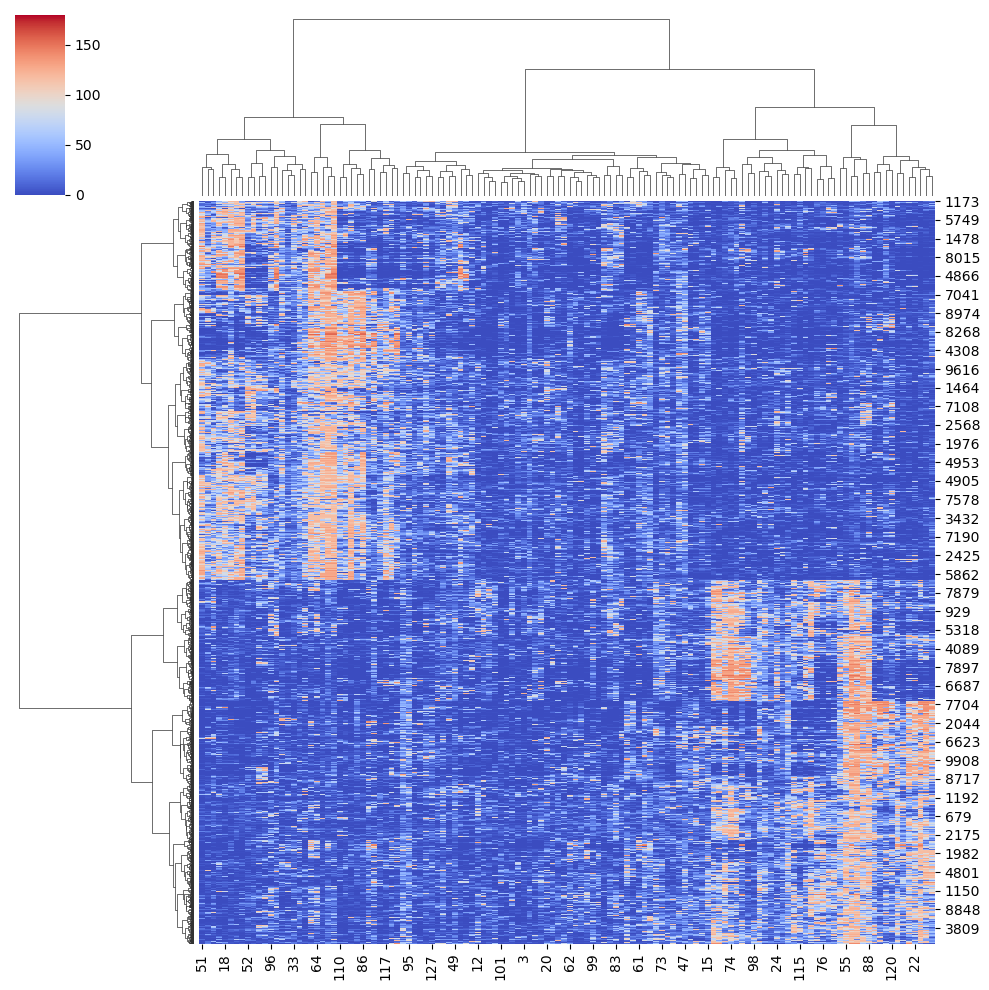

In [4]:
if DATASET == "siftsmall":
    sns.clustermap(search_data, metric='euclidean', cmap='coolwarm', method='ward', figsize=(10, 10))
    plt.show()

In [5]:
M = 8
K = 256
pq = PQ(M=M, K=K, seed=RANDOM_SEED)

print("Training the PQ quantizer...")
start_training = time.time()
pq.train(tr_data, add=False, verbose=True)
training_time = time.time() - start_training
start_adding = time.time()
pq.add(search_data)
adding_time = time.time() - start_adding

print("--------------------")
print(f"Training time: {training_time:.2f} s")
print(f"Adding time: {adding_time:.2f} s")
print(f"Compressed data shape: {pq.pqcode.shape}")
print(f"Compressed data size: {pq.pqcode.nbytes} bytes")
print(f"Original data size: {tr_data.nbytes} bytes")
print(f"Compression factor: {tr_data.nbytes / pq.pqcode.nbytes:.2f}")

compressed_tr = pq.compress(tr_data)
decompressed_tr = pq.decompress(compressed_tr) 
error_tr = NMSE(tr_data, decompressed_tr)
print(f"Reconstruction error (NMSE) on training data: {error_tr:.3f}")

decompressed_search = pq.decompress(pq.pqcode)
error_search = NMSE(search_data, decompressed_search)
print(f"Reconstruction error (NMSE) on search data: {error_search:.3f}")

start_training_d = time.time()
pq.train(tr_data, add=False, verbose=True)
training_time_d = time.time() - start_training_d
start_adding_d = time.time()
pq.add(search_data, compute_distortions=True)
adding_time_d = time.time() - start_adding_d

print("--------------------")
print(f"Training time with average distortion computation: {training_time_d:.2f} s")
print(f"Adding time with average distortion computation: {adding_time_d:.2f} s")
print(f"Compressed data shape with average distortion: {pq.pqcode.shape} + {pq.avg_dist.shape}")
print(f"Compressed data with average distortion size: {pq.pqcode.nbytes + pq.avg_dist.nbytes} bytes")
print(f"Original data size: {tr_data.nbytes} bytes")
print(f"Compression factor with average distortion: {tr_data.nbytes / (pq.pqcode.nbytes + pq.avg_dist.nbytes):.2f}")

Training the PQ quantizer...
KMeans on subspace 1 converged in 77 iterations.
KMeans on subspace 2 converged in 79 iterations.
KMeans on subspace 3 converged in 60 iterations.
KMeans on subspace 4 converged in 60 iterations.
KMeans on subspace 5 converged in 55 iterations.
KMeans on subspace 6 converged in 76 iterations.
KMeans on subspace 7 converged in 50 iterations.
KMeans on subspace 8 converged in 68 iterations.
--------------------
Training time: 4.27 s
Adding time: 0.08 s
Compressed data shape: (10000, 8)
Compressed data size: 80000 bytes
Original data size: 12800000 bytes
Compression factor: 160.00
Reconstruction error (NMSE) on training data: 0.089
Reconstruction error (NMSE) on search data: 0.095
KMeans on subspace 1 converged in 77 iterations.
KMeans on subspace 2 converged in 79 iterations.
KMeans on subspace 3 converged in 60 iterations.
KMeans on subspace 4 converged in 60 iterations.
KMeans on subspace 5 converged in 55 iterations.
KMeans on subspace 6 converged in 76 it

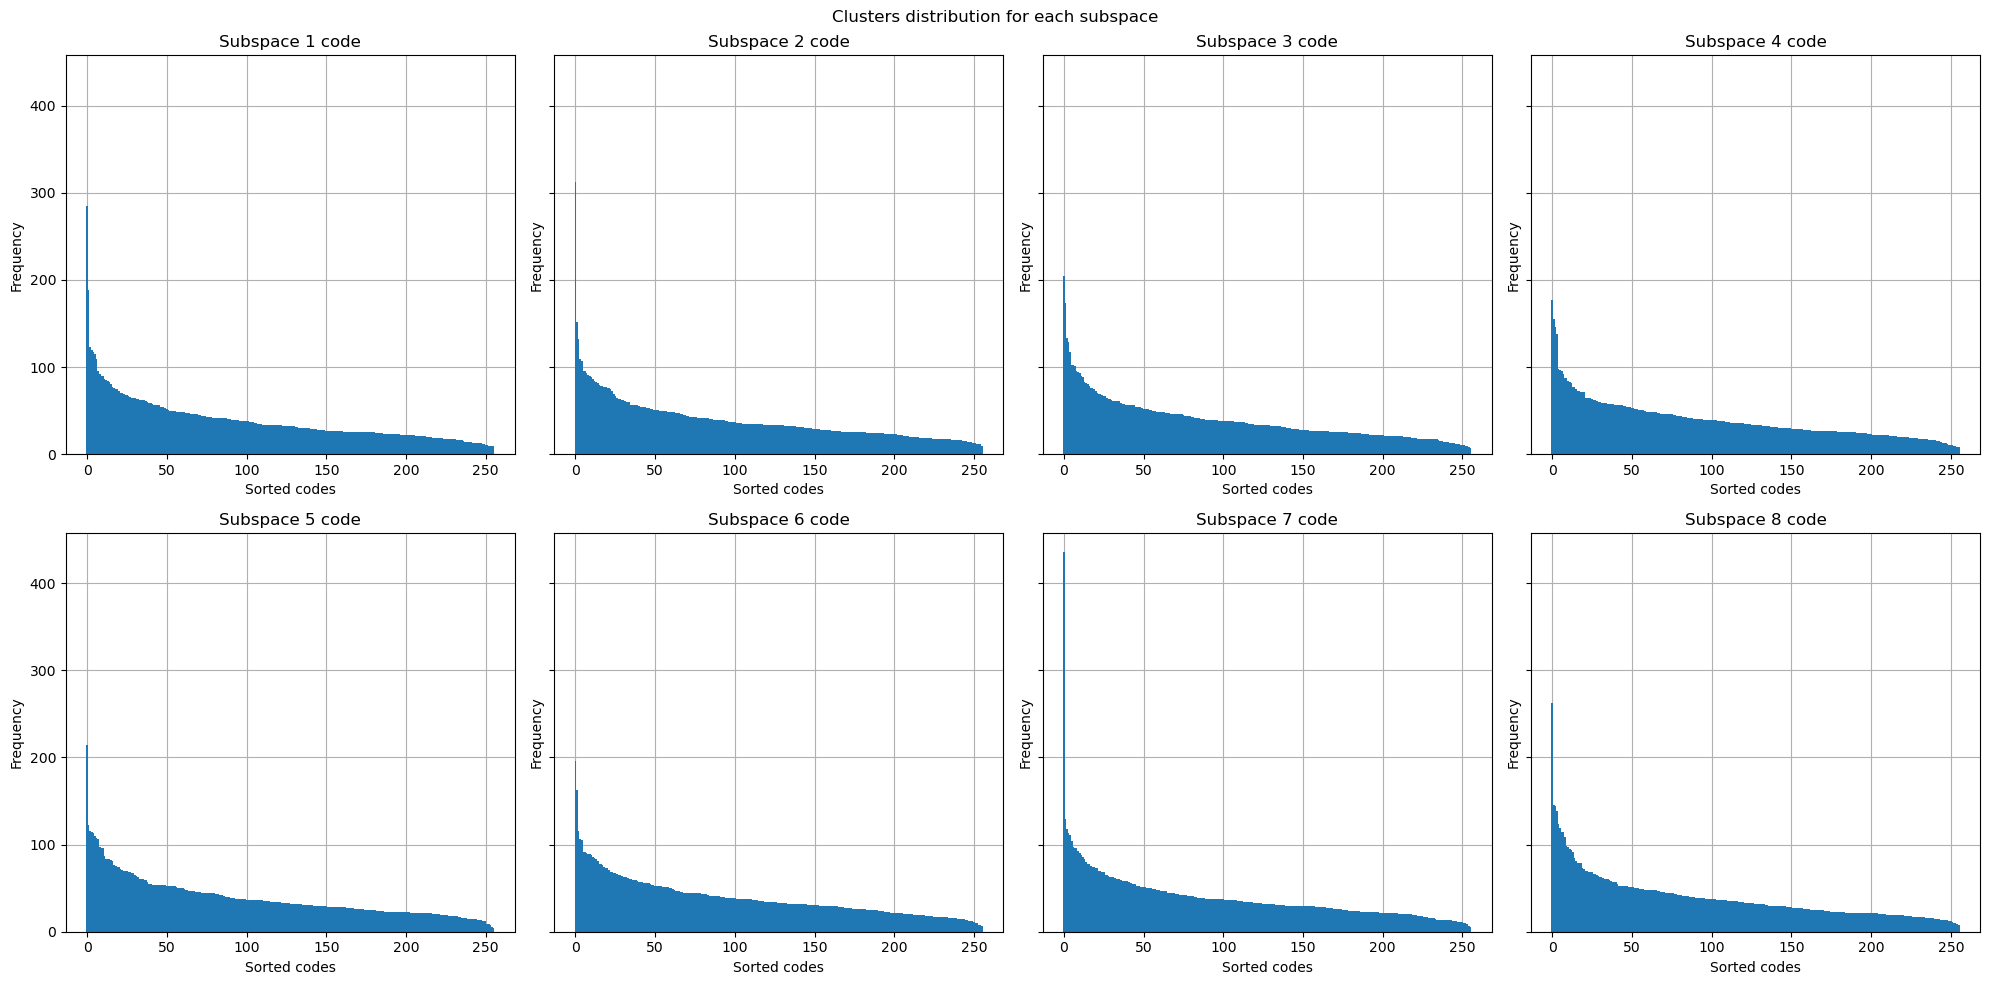

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10), sharey=True)
id = 0
for m in range(pq.M):
    hist, bins = np.histogram(pq.pqcode[:, m], bins=range(pq.K+1))
    hist = sorted(hist, reverse=True)
    axs[int(id/4)][id%4].bar(bins[:-1], hist, width=1)
    axs[int(id/4)][id%4].set_title(f"Subspace {m+1} code")
    axs[int(id/4)][id%4].set_xlabel("Sorted codes")
    axs[int(id/4)][id%4].set_ylabel("Frequency")
    axs[int(id/4)][id%4].grid()
    axs[int(id/4)][id%4].set_axisbelow(True)
    id += 1

plt.suptitle("Clusters distribution for each subspace")
plt.tight_layout()
plt.show()

In [7]:
asym_pq_dists, asym_ranking = pq.search(sample_query, subset=None, asym=True, correct=False)
asym_pq_corr_dists, asym_corr_ranking = pq.search(sample_query, subset=None, asym=True, correct=True)
sym_pq_dists, sym_ranking = pq.search(sample_query, subset=None, asym=False, correct=False)
sym_pq_corr_dists, sym_corr_ranking = pq.search(sample_query, subset=None, asym=False, correct=True)
es = ExactSearch(search_data)
exact_dists, exact_ranking = es.search(sample_query)

In [8]:
# check if computed exact ranking is equal to ground truth
np.all(gt[0][:100]==exact_ranking[:100])

True

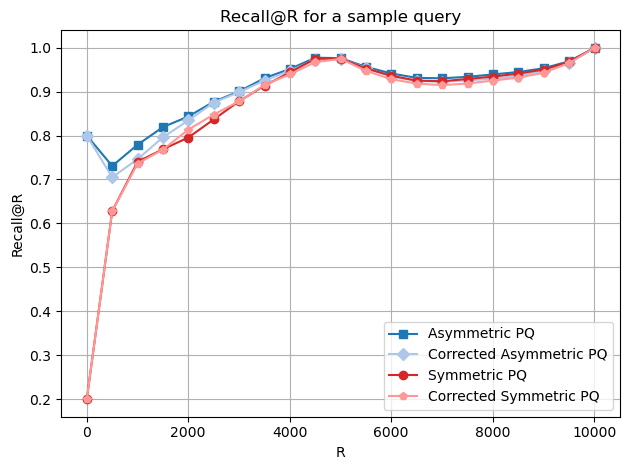

In [9]:
recalls = {"Asymmetric PQ": [], "Corrected Asymmetric PQ": [], "Symmetric PQ": [], "Corrected Symmetric PQ": []}
step = 500 if DATASET == "siftsmall" else 100000
rs = range(5, search_data.shape[0] + step, step)
for r in rs:
    recalls["Asymmetric PQ"].append(recall_at_r(asym_ranking, exact_ranking, r))
    recalls["Corrected Asymmetric PQ"].append(recall_at_r(asym_corr_ranking, exact_ranking, r))
    recalls["Symmetric PQ"].append(recall_at_r(sym_ranking, exact_ranking, r))
    recalls["Corrected Symmetric PQ"].append(recall_at_r(sym_corr_ranking, exact_ranking, r))

plt.plot(rs, recalls["Asymmetric PQ"], '-s', label="Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
plt.plot(rs, recalls["Corrected Asymmetric PQ"], '-D', label="Corrected Asymmetric PQ", color=matplotlib.colormaps["tab20"](1))
plt.plot(rs, recalls["Symmetric PQ"], '-o', label="Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
plt.plot(rs, recalls["Corrected Symmetric PQ"], '-p', label="Corrected Symmetric PQ", color=matplotlib.colormaps["tab20"](7))
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.title('Recall@R for a sample query')
plt.grid(zorder=0)
plt.tight_layout()
plt.legend();

In [10]:
APs = {}
APs["Asymmetric PQ"] = AP(asym_ranking[:50], exact_ranking[:50])
APs["Symmetric PQ"] = AP(sym_ranking[:50], exact_ranking[:50])
pd.DataFrame(APs, index=["AP"])

,Asymmetric PQ,Symmetric PQ
AP,0.746467,0.570353


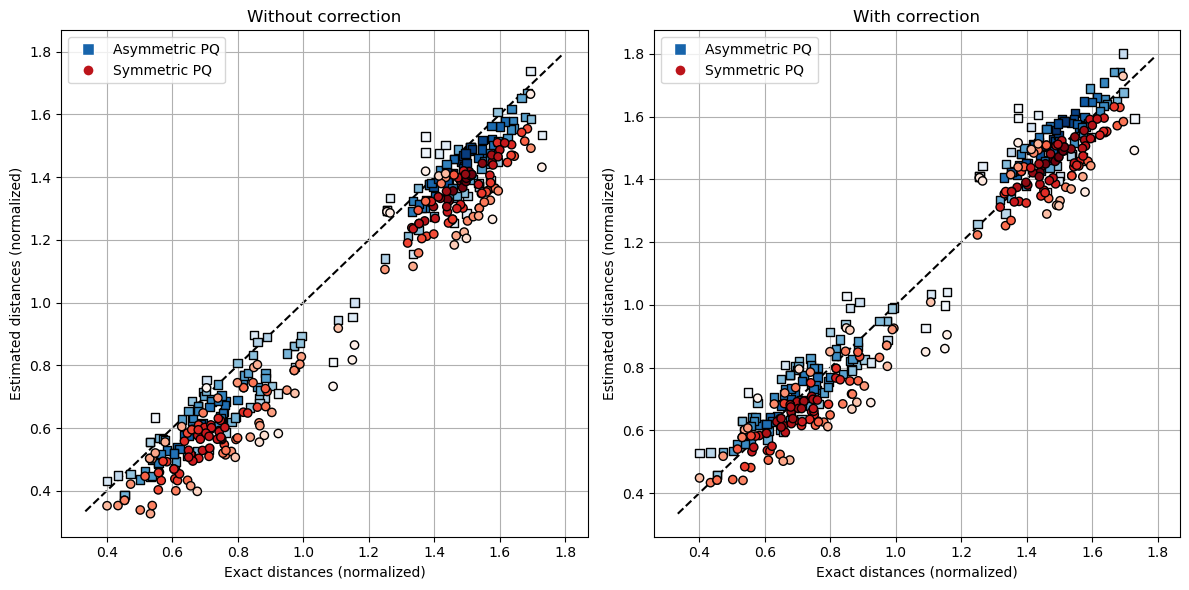

In [11]:
def plot_exact_vs_estimated(axs, exact_dists, asym_pq_dists, sym_pq_dists, query):
    query_snorm = np.sum(np.square(query))
    exact_dists = exact_dists / query_snorm
    asym_pq_dists = asym_pq_dists / query_snorm
    sym_pq_dists = sym_pq_dists / query_snorm
    
    xy_asym = np.vstack([exact_dists, asym_pq_dists])
    kernel_asym = gaussian_kde(xy_asym)(xy_asym)
    axs.scatter(
        exact_dists,
        asym_pq_dists,
        c=kernel_asym,
        cmap="Blues", edgecolor='black', label="Asymmetric PQ",
        zorder=2, marker='s')

    xy_sym = np.vstack([exact_dists, sym_pq_dists])
    kernel_sym = gaussian_kde(xy_sym)(xy_sym)
    axs.scatter(
        exact_dists,
        sym_pq_dists,
        c=kernel_sym,
        cmap="Reds", edgecolor='black', label="Symmetric PQ",
        zorder=2, marker='o')

    axs.set_xlabel("Exact distances (normalized)")
    axs.set_ylabel("Estimated distances (normalized)")
    xpoints = axs.get_xlim()
    axs.plot(xpoints, xpoints, linestyle='--', color='black', zorder=1)
    axs.grid(zorder=0)
    legend_elements = [
        Line2D([0], [0], marker='s', color='w', label='Asymmetric PQ', markersize=8,
            markerfacecolor=matplotlib.colormaps['Blues'](0.8)),
        Line2D([0], [0], marker='o', color='w', label='Symmetric PQ', markersize=8,
            markerfacecolor=matplotlib.colormaps['Reds'](0.8))
    ] # TODO: white border is missing
    axs.legend(handles=legend_elements);

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
SAMPLE_SIZE = 200
sample = np.random.randint(0, 1000, SAMPLE_SIZE)
plot_exact_vs_estimated(axs[0], exact_dists[sample], asym_pq_dists[sample], sym_pq_dists[sample], sample_query)
axs[0].set_title("Without correction")
plot_exact_vs_estimated(axs[1], exact_dists[sample], asym_pq_corr_dists[sample], sym_pq_corr_dists[sample], sample_query)
axs[1].set_title("With correction");
plt.tight_layout()

In [12]:
asym_diffs = np.zeros((search_data.shape[0]*queries.shape[0]))
asym_diffs_corr = np.zeros((search_data.shape[0]*queries.shape[0]))
sym_diffs = np.zeros((search_data.shape[0]*queries.shape[0]))
sym_diffs_corr = np.zeros((search_data.shape[0]*queries.shape[0]))

R = [1, 10, 100, 1000, 10000]
if DATASET == "sift":
    R += [100000, 1000000]
asym_recall = np.zeros((len(queries), len(R)))
asym_corr_recall = np.zeros((len(queries), len(R)))
sym_recall = np.zeros((len(queries), len(R)))
sym_corr_recall = np.zeros((len(queries), len(R)))

exact_nearest = np.empty(len(queries))
mean_es_time = 0

for i, query in enumerate(queries):
    asym_d_est, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
    asym_d_est_corr, asym_corr_rank = pq.search(query, subset=None, asym=True, correct=True)
    sym_d_est, sym_rank = pq.search(query, subset=None, asym=False, correct=False)
    sym_d_est_corr, sym_corr_rank = pq.search(query, subset=None, asym=False, correct=True)
    start_search_time = time.time()
    d, rank = es.search(query)
    mean_es_time += time.time() - start_search_time
    exact_nearest[i] = rank[0]
    query_norm = np.sum(np.square(query))
    asym_diffs[i*search_data.shape[0]:(i+1)*search_data.shape[0]] = (asym_d_est-d) / query_norm
    asym_diffs_corr[i*search_data.shape[0]:(i+1)*search_data.shape[0]] = (asym_d_est_corr-d) / query_norm
    sym_diffs[i*search_data.shape[0]:(i+1)*search_data.shape[0]] = (sym_d_est-d) / query_norm
    sym_diffs_corr[i*search_data.shape[0]:(i+1)*search_data.shape[0]] = (sym_d_est_corr-d) / query_norm

    for j, r in enumerate(R):
        asym_recall[i][j] = exact_nearest[i] in asym_rank[:r]
        asym_corr_recall[i][j] = exact_nearest[i] in asym_corr_rank[:r]
        sym_recall[i][j] = exact_nearest[i] in sym_rank[:r]
        sym_corr_recall[i][j] = exact_nearest[i] in sym_corr_rank[:r]

mean_es_time /= len(queries)

asym_recall_mean = np.mean(asym_recall, axis=0)
asym_corr_recall_mean = np.mean(asym_corr_recall, axis=0)
sym_recall_mean = np.mean(sym_recall, axis=0)
sym_corr_recall_mean = np.mean(sym_corr_recall, axis=0)

asym_recall_yerr = [
    asym_recall_mean - np.min(asym_recall, axis=0),
    np.max(asym_recall, axis=0) - asym_recall_mean
]
asym_corr_recall_yerr = [
    asym_corr_recall_mean - np.min(asym_corr_recall, axis=0),
    np.max(asym_corr_recall, axis=0) - asym_corr_recall_mean
]
sym_recall_yerr = [
    sym_recall_mean - np.min(sym_recall, axis=0),
    np.max(sym_recall, axis=0) - sym_recall_mean
]
sym_corr_recall_yerr = [
    sym_corr_recall_mean - np.min(sym_corr_recall, axis=0),
    np.max(sym_corr_recall, axis=0) - sym_corr_recall_mean
]

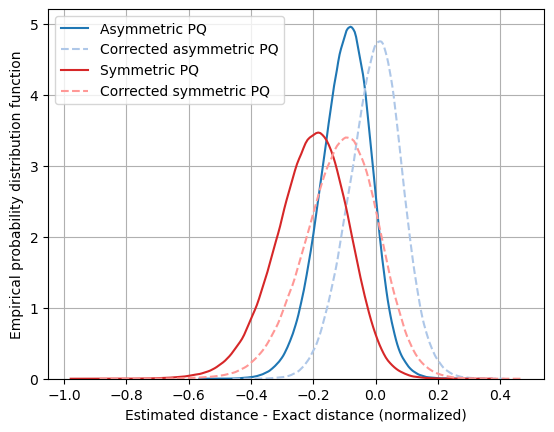

In [13]:
sns.kdeplot(asym_diffs, label="Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
sns.kdeplot(asym_diffs_corr, label="Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1), linestyle='dashed')
sns.kdeplot(sym_diffs, label="Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
sns.kdeplot(sym_diffs_corr, label="Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7), linestyle='dashed')
plt.xlabel("Estimated distance - Exact distance (normalized)")
plt.ylabel("Empirical probability distribution function")
plt.legend();
plt.grid()

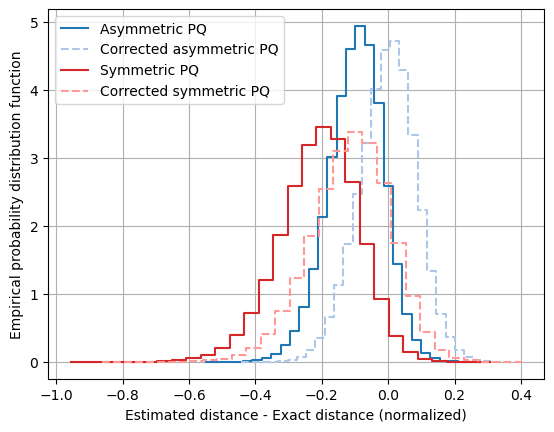

In [14]:
bins = 30

hist_asym, bin_edges_asym = np.histogram(asym_diffs, bins=bins, density=True)
plt.step(bin_edges_asym[:-1], hist_asym, where='post', label="Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))

hist_asym_corr, bin_edges_asym_corr = np.histogram(asym_diffs_corr, bins=bins, density=True)
plt.step(bin_edges_asym_corr[:-1], hist_asym_corr, where='post', label="Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1), linestyle='dashed')

hist_sym, bin_edges_sym = np.histogram(sym_diffs, bins=bins, density=True)
plt.step(bin_edges_sym[:-1], hist_sym, where='post', label="Symmetric PQ", color=matplotlib.colormaps["tab20"](6))

hist_sym_corr, bin_edges_sym_corr = np.histogram(sym_diffs_corr, bins=bins, density=True)
plt.step(bin_edges_sym_corr[:-1], hist_sym_corr, where='post', label="Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7), linestyle='dashed')

plt.xlabel("Estimated distance - Exact distance (normalized)")
plt.ylabel("Empirical probability distribution function")
plt.legend()
plt.grid()

In [15]:
asym_diff_var = np.var(asym_diffs)
asym_corr_diff_var = np.var(asym_diffs_corr)
sym_diff_var = np.var(sym_diffs)
sym_corr_diff_var = np.var(sym_diffs_corr)
pd.DataFrame({
    "Asymmetric PQ": [asym_diff_var],
    "Corrected asymmetric PQ": [asym_corr_diff_var],
    "Symmetric PQ": [sym_diff_var],
    "Corrected symmetric PQ": [sym_corr_diff_var],
    }, index=["Variance of error"])

,Asymmetric PQ,Corrected asymmetric PQ,Symmetric PQ,Corrected symmetric PQ
Variance of error,0.006804,0.007472,0.01367,0.014333


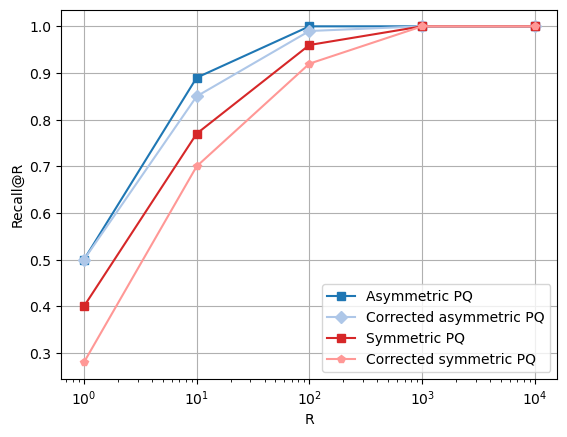

In [16]:
# plt.errorbar(R, asym_recall_mean, yerr=asym_recall_yerr, fmt='-s', label="Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
# plt.errorbar(R, asym_corr_recall_mean, yerr=asym_corr_recall_yerr, fmt='-o', label="Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1))
# plt.errorbar(R, sym_recall_mean, yerr=sym_recall_yerr, fmt='-s', label="Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
# plt.errorbar(R, sym_corr_recall_mean, yerr=sym_corr_recall_yerr, fmt='-o', label="Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7))
plt.plot(R, asym_recall_mean, '-s', label="Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, asym_corr_recall_mean, '-D', label="Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1))
plt.plot(R, sym_recall_mean, '-s', label="Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, sym_corr_recall_mean, '-p', label="Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.legend()
plt.grid()

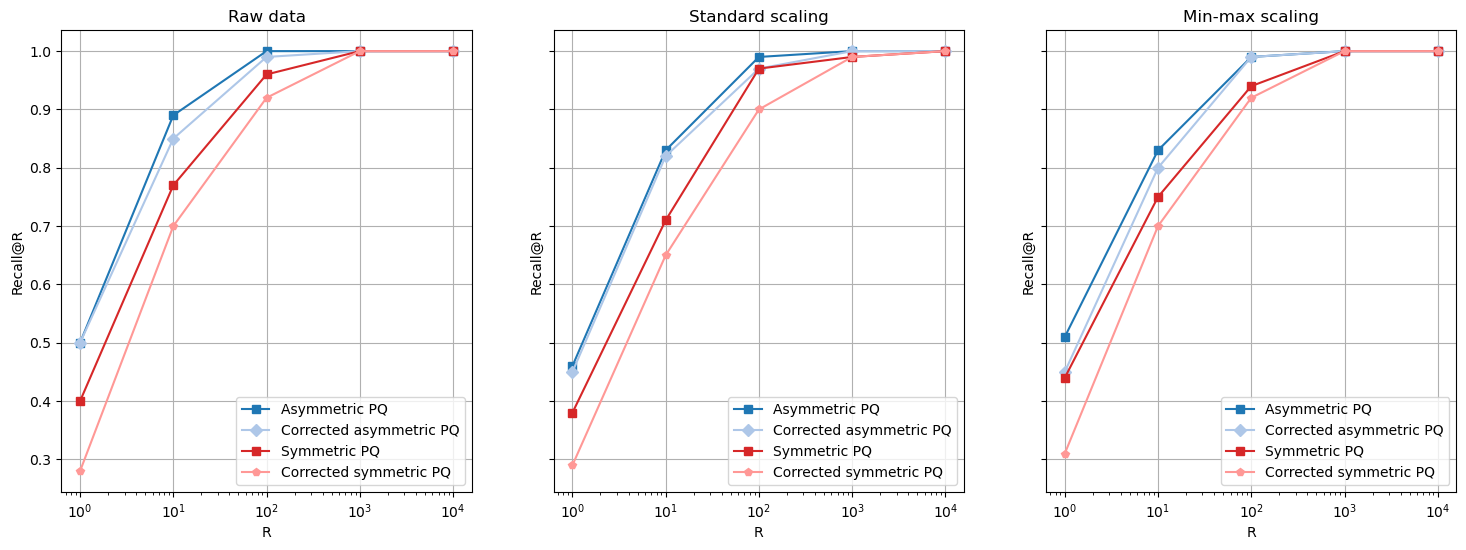

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

std_scaler = StandardScaler()
tr_data_std = std_scaler.fit_transform(tr_data)
search_data_std = std_scaler.transform(search_data)
queries_std = std_scaler.transform(queries)
minmax_scaler = MinMaxScaler()
tr_data_minmax = minmax_scaler.fit_transform(tr_data)
search_data_minmax = minmax_scaler.transform(search_data)
queries_minmax = minmax_scaler.transform(queries)

def train_search(M, K, seed, R, tr_data, search_data, queries):
    pq = PQ(M=M, K=K, seed=seed)
    pq.train(tr_data, add=False)
    pq.add(search_data, compute_distortions=True)

    asym_recall = np.zeros((len(queries), len(R)))
    asym_corr_recall = np.zeros((len(queries), len(R)))
    sym_recall = np.zeros((len(queries), len(R)))
    sym_corr_recall = np.zeros((len(queries), len(R)))

    for i, query in enumerate(queries):
        _, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
        _, asym_corr_rank = pq.search(query, subset=None, asym=True, correct=True)
        _, sym_rank = pq.search(query, subset=None, asym=False, correct=False)
        _, sym_corr_rank = pq.search(query, subset=None, asym=False, correct=True)
    
        for j, r in enumerate(R):
            asym_recall[i][j] = exact_nearest[i] in asym_rank[:r]
            asym_corr_recall[i][j] = exact_nearest[i] in asym_corr_rank[:r]
            sym_recall[i][j] = exact_nearest[i] in sym_rank[:r]
            sym_corr_recall[i][j] = exact_nearest[i] in sym_corr_rank[:r]

    asym_recall_mean = np.mean(asym_recall, axis=0)
    asym_corr_recall_mean = np.mean(asym_corr_recall, axis=0)
    sym_recall_mean = np.mean(sym_recall, axis=0)
    sym_corr_recall_mean = np.mean(sym_corr_recall, axis=0)

    results = {
        "asym_recall_mean": asym_recall_mean,
        "asym_corr_recall_mean": asym_corr_recall_mean,
        "sym_recall_mean": sym_recall_mean,
        "sym_corr_recall_mean": sym_corr_recall_mean
    }

    return results

results = {
    "asym_recall_mean": asym_recall_mean,
    "asym_corr_recall_mean": asym_corr_recall_mean,
    "sym_recall_mean": sym_recall_mean,
    "sym_corr_recall_mean": sym_corr_recall_mean
}
results_std = train_search(M, K, RANDOM_SEED, R, tr_data_std, search_data_std, queries_std)
results_minmax = train_search(M, K, RANDOM_SEED, R, tr_data_minmax, search_data_minmax, queries_minmax)

fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

scaling_methods = [
    ("Raw data", results),
    ("Standard scaling", results_std),
    ("Min-max scaling", results_minmax)
]

for ax, (title, data) in zip(axs, scaling_methods):
    ax.plot(R, data["asym_recall_mean"], '-s', label="Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
    ax.plot(R, data["asym_corr_recall_mean"], '-D', label="Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1))
    ax.plot(R, data["sym_recall_mean"], '-s', label="Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
    ax.plot(R, data["sym_corr_recall_mean"], '-p', label="Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7))
    ax.set_xscale('log')
    ax.set_xlabel('R')
    ax.set_ylabel('Recall@R')
    ax.set_title(title)
    ax.legend()
    ax.grid()

In [18]:
if DATASET == "siftsmall":
    KP = 128
    W = 4
else:
    KP = 1024
    W = 8
ivf = IVF(Kp=KP, M=M, K=K, seed=RANDOM_SEED)
start_training = time.time()
ivf.train(tr_data, add=False)
end_training = time.time() - start_training
start_adding = time.time()
ivf.add(search_data, compute_distortions=True)
end_adding = time.time() - start_adding

print(f"Training time (with avg dist computation): {end_training:.2f} s")
print(f"Adding time (with avg dist computation): {end_adding:.2f} s")

Training time (with avg dist computation): 5.86 s
Adding time (with avg dist computation): 0.25 s


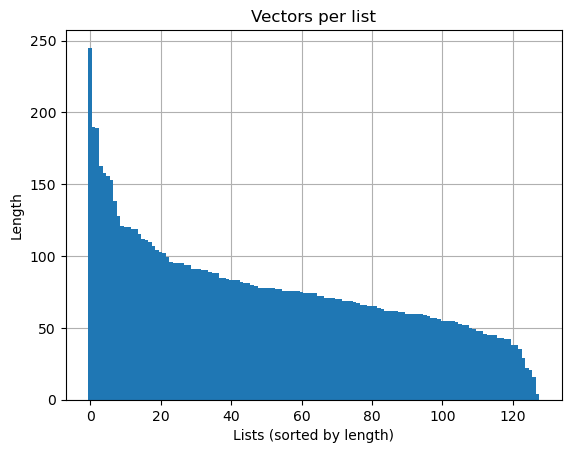

In [19]:
els_per_cluster = []
for i in range(ivf.Kp):
    els_per_cluster.append(len(ivf.ivf[i]))
fig, axs = plt.subplots(1)
axs.bar(range(ivf.Kp), sorted(els_per_cluster, reverse=True), width=1.0)
axs.set_xlabel("Lists (sorted by length)")
axs.set_ylabel("Length")
axs.set_title("Vectors per list")
axs.set_axisbelow(True)
axs.grid()

In [20]:
ivf_asym_recall = np.full((len(queries), len(R)), np.nan)
ivf_asym_corr_recall = np.full((len(queries), len(R)), np.nan)
ivf_sym_recall = np.full((len(queries), len(R)), np.nan)
ivf_sym_corr_recall = np.full((len(queries), len(R)), np.nan)

for i, query in enumerate(queries):
    _, ivf_asym_rank = ivf.search(query, w=W, asym=True, correct=False)
    _, ivf_asym_corr_rank = ivf.search(query, w=W, asym=True, correct=True)
    _, ivf_sym_rank = ivf.search(query, w=W, asym=False, correct=False)
    _, ivf_sym_corr_rank = ivf.search(query, w=W, asym=False, correct=True)
    query_norm = np.sum(np.square(query))

    for j, r in enumerate(R):
        if r < len(ivf_asym_rank):
            ivf_asym_recall[i][j] = exact_nearest[i] in ivf_asym_rank[:r]
        if r < len(ivf_asym_corr_rank):
            ivf_asym_corr_recall[i][j] = exact_nearest[i] in ivf_asym_corr_rank[:r]
        if r < len(ivf_sym_rank):
            ivf_sym_recall[i][j] = exact_nearest[i] in ivf_sym_rank[:r]
        if r < len(ivf_sym_corr_rank):
            ivf_sym_corr_recall[i][j] = exact_nearest[i] in ivf_sym_corr_rank[:r]

ivf_asym_recall_mean = np.nanmean(ivf_asym_recall, axis=0)
ivf_asym_corr_recall_mean = np.nanmean(ivf_asym_corr_recall, axis=0)
ivf_sym_recall_mean = np.nanmean(ivf_sym_recall, axis=0)
ivf_sym_corr_recall_mean = np.nanmean(ivf_sym_corr_recall, axis=0)

ivf_asym_recall_yerr = [
    ivf_asym_recall_mean - np.min(ivf_asym_recall, axis=0),
    np.max(ivf_asym_recall, axis=0) - ivf_asym_recall_mean
]
ivf_asym_corr_recall_yerr = [
    ivf_asym_corr_recall_mean - np.min(ivf_asym_corr_recall, axis=0),
    np.max(ivf_asym_corr_recall, axis=0) - ivf_asym_corr_recall_mean
]
ivf_sym_recall_yerr = [
    ivf_sym_recall_mean - np.min(ivf_sym_recall, axis=0),
    np.max(ivf_sym_recall, axis=0) - ivf_sym_recall_mean
]
ivf_sym_corr_recall_yerr = [
    ivf_sym_corr_recall_mean - np.min(ivf_sym_corr_recall, axis=0),
    np.max(ivf_sym_corr_recall, axis=0) - ivf_sym_corr_recall_mean
]

/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_13891/1488569243.py:23: RuntimeWarning: Mean of empty slice
  ivf_asym_recall_mean = np.nanmean(ivf_asym_recall, axis=0)
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_13891/1488569243.py:24: RuntimeWarning: Mean of empty slice
  ivf_asym_corr_recall_mean = np.nanmean(ivf_asym_corr_recall, axis=0)
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_13891/1488569243.py:25: RuntimeWarning: Mean of empty slice
  ivf_sym_recall_mean = np.nanmean(ivf_sym_recall, axis=0)
/var/folders/8n/f3j9y6bd3zd_kp83y0vvn_b80000gn/T/ipykernel_13891/1488569243.py:26: RuntimeWarning: Mean of empty slice
  ivf_sym_corr_recall_mean = np.nanmean(ivf_sym_corr_recall, axis=0)


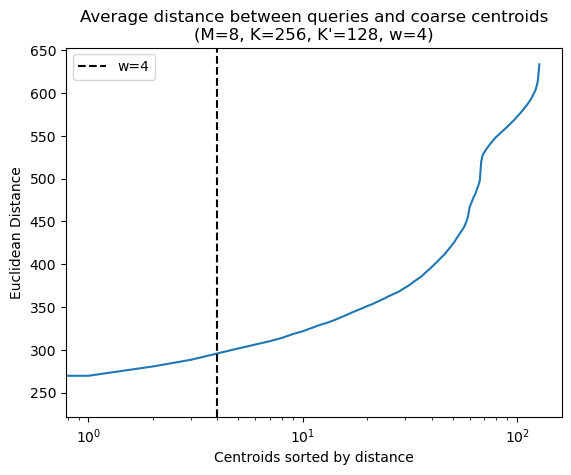

In [21]:
mean_dists2centroids = np.zeros(ivf.Kp)

for i, query in enumerate(queries):
    _, ivf_asym_rank = ivf.search(query, w=W, asym=True, correct=False)
    dist2centroids = cdist([query], ivf.centroids, 'euclidean')[0]
    sorteddist2centroids = np.sort(dist2centroids)
    mean_dists2centroids += sorteddist2centroids

mean_dists2centroids /= len(queries)
plt.plot(mean_dists2centroids)
plt.xlabel("Centroids sorted by distance")
plt.ylabel("Euclidean Distance")
plt.axvline(x=W, color='k', linestyle='--', label=f"w={W}")
plt.xscale('log')
plt.legend()
plt.title(f"Average distance between queries and coarse centroids\n(M={M}, K={K}, K'={KP}, w={W})");

These warnings occur when the number of retrieved elements is less than the value in R.

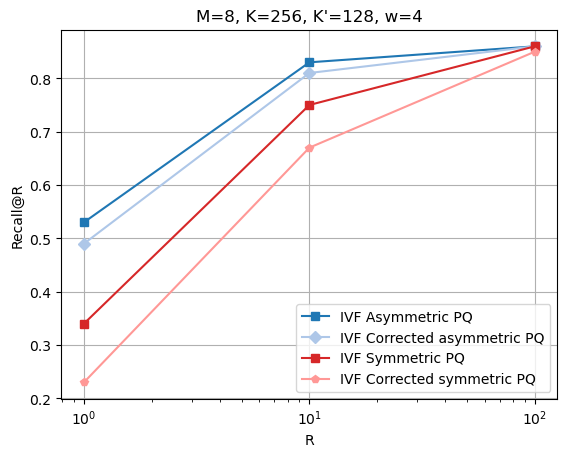

In [22]:
# plt.errorbar(R, ivf_asym_recall_mean, yerr=ivf_asym_recall_yerr, fmt='-s', label="IVF Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
# plt.errorbar(R, ivf_asym_corr_recall_mean, yerr=ivf_asym_corr_recall_yerr, fmt='-o', label="IVF Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1))
# plt.errorbar(R, ivf_sym_recall_mean, yerr=ivf_sym_recall_yerr, fmt='-s', label="IVF Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
# plt.errorbar(R, ivf_sym_corr_recall_mean, yerr=ivf_sym_corr_recall_yerr, fmt='-o', label="IVF Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7))
plt.plot(R, ivf_asym_recall_mean, '-s', label="IVF Asymmetric PQ", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, ivf_asym_corr_recall_mean, '-D', label="IVF Corrected asymmetric PQ", color=matplotlib.colormaps["tab20"](1))
plt.plot(R, ivf_sym_recall_mean, '-s', label="IVF Symmetric PQ", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, ivf_sym_corr_recall_mean, '-p', label="IVF Corrected symmetric PQ", color=matplotlib.colormaps["tab20"](7))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.title(f"M={M}, K={K}, K'={KP}, w={W}")
plt.legend()
plt.grid()

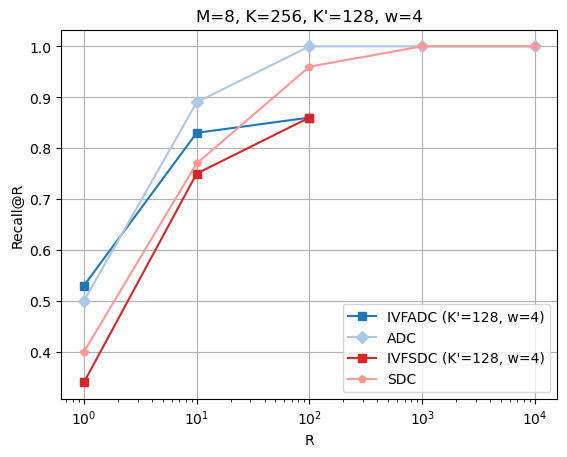

In [23]:
plt.plot(R, ivf_asym_recall_mean, '-s', label=f"IVFADC (K'={KP}, w={W})", color=matplotlib.colormaps["tab20"](0))
plt.plot(R, asym_recall_mean, '-D', label="ADC", color=matplotlib.colormaps["tab20"](1))
plt.plot(R, ivf_sym_recall_mean, '-s', label=f"IVFSDC (K'={KP}, w={W})", color=matplotlib.colormaps["tab20"](6))
plt.plot(R, sym_recall_mean, '-p', label="SDC", color=matplotlib.colormaps["tab20"](7))
plt.xscale('log')
plt.xlabel('R')
plt.ylabel('Recall@R')
plt.title(f"M={M}, K={K}, K'={KP}, w={W}")
plt.legend()
plt.grid()

In [24]:
Ms = [1, 2, 4, 8, 16]
Ks = [16, 64, 256, 1024]

training_results = []
search_results = []

for m in Ms:
    for r in Ks:
        print(f"Training PQ with M={m}, K={r}...")
        
        pq = PQ(M=m, K=r, seed=RANDOM_SEED)
        start_training = time.time()
        pq.train(tr_data)
        training_time = time.time() - start_training
        start_adding = time.time()
        pq.add(search_data)
        adding_time = time.time() - start_adding
        
        decompressed_search = pq.decompress(pq.pqcode) 
        search_NMSE = NMSE(search_data, decompressed_search)
        compressed_tr = pq.compress(tr_data)
        decompressed_tr = pq.decompress(compressed_tr)
        tr_NMSE = NMSE(tr_data, decompressed_tr)

        code_length = np.log2(r) * m
        curr_training_res = {"M": m, "K": r, "Code length [bits]": code_length,
                  "Training time [s]": training_time, "Adding time [s]": adding_time,
                  "TR NMSE": tr_NMSE,
                  "SEARCH NMSE": search_NMSE}
        training_results.append(curr_training_res)
        
        for asym in [True, False]:
            mean_search_time = 0
            recall = 0
            for i, query in enumerate(queries):
                start_search = time.time()
                _, ranking = pq.search(query, subset=None, asym=asym, correct=False)
                mean_search_time += (time.time() - start_search)
                if exact_nearest[i] in ranking[:100]:
                    recall += 1
            mean_search_time /= len(queries)
            recall /= len(queries)
            
            curr_search_res = {"M": m, "K": r, "Code length [bits]": code_length,
                          "Asymmetric Distance": asym,
                          "Mean search time [ms]": mean_search_time*1000,
                          "Recall@100": recall}
            search_results.append(curr_search_res)

training_results = pd.DataFrame(training_results)
search_results = pd.DataFrame(search_results)

Training PQ with M=1, K=16...
Training PQ with M=1, K=64...
Training PQ with M=1, K=256...
Training PQ with M=1, K=1024...
Training PQ with M=2, K=16...
Training PQ with M=2, K=64...
Training PQ with M=2, K=256...
Training PQ with M=2, K=1024...
Training PQ with M=4, K=16...
Training PQ with M=4, K=64...
Training PQ with M=4, K=256...
Training PQ with M=4, K=1024...
Training PQ with M=8, K=16...
Training PQ with M=8, K=64...
Training PQ with M=8, K=256...
Training PQ with M=8, K=1024...
Training PQ with M=16, K=16...
Training PQ with M=16, K=64...
Training PQ with M=16, K=256...
Training PQ with M=16, K=1024...


In [25]:
training_results

,M,K,Code length [bits],Training time [s],Adding time [s],TR NMSE,SEARCH NMSE
0,1,16,4.0,0.459125,0.003267,0.295403,0.295698
1,1,64,6.0,1.099577,0.005100,0.254209,0.257719
2,1,256,8.0,3.159332,0.012307,0.220694,0.229798
3,1,1024,10.0,9.369534,0.043984,0.186407,0.211102
4,2,16,8.0,1.000299,0.004846,0.273406,0.276041
5,2,64,12.0,1.653582,0.011317,0.226354,0.229237
6,2,256,16.0,3.392399,0.015881,0.187151,0.195927
7,2,1024,20.0,11.003247,0.051557,0.150360,0.172441
8,4,16,16.0,1.931073,0.007818,0.247365,0.250464
9,4,64,24.0,2.298852,0.010344,0.191399,0.194884


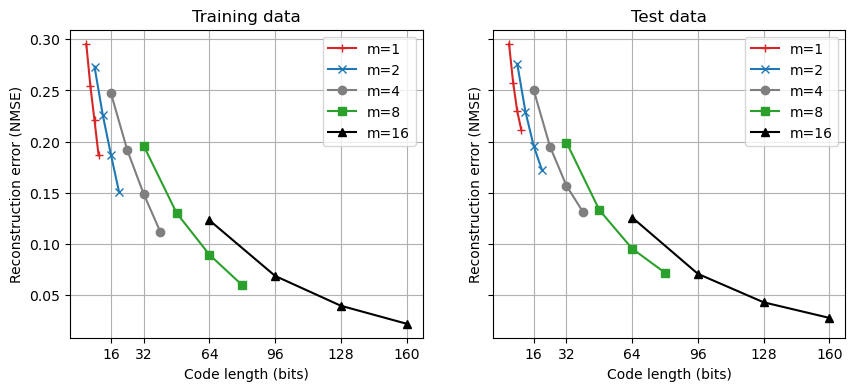

In [26]:
colors = ['tab:red', 'tab:blue', 'tab:gray', 'tab:green', 'black']
markers = ['+', 'x', 'o', 's', '^']

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, m in enumerate(Ms):
    res = training_results[training_results["M"]==m]
    axs[0].plot(res["Code length [bits]"], res["TR NMSE"], marker=markers[i], color=colors[i], label=f"m={m}")
    axs[1].plot(res["Code length [bits]"], res["SEARCH NMSE"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].set_xticks([16, 32, 64, 96, 128, 160])
axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Reconstruction error (NMSE)")
axs[0].set_title("Training data")
axs[0].legend()
axs[0].grid()
axs[1].set_xticks([16, 32, 64, 96, 128, 160])
axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Reconstruction error (NMSE)")
axs[1].set_title("Test data")
axs[1].legend()
axs[1].grid()

In [27]:
print(f"Mean Exact Search time: {mean_es_time*1000} [ms]")
search_results

Mean Exact Search time: 1.411423683166504 [ms]


,M,K,Code length [bits],Asymmetric Distance,Mean search time [ms],Recall@100
0,1,16,4.0,True,0.508463,0.19
1,1,16,4.0,False,0.506685,0.14
2,1,64,6.0,True,0.549951,0.38
3,1,64,6.0,False,0.948493,0.31
4,1,256,8.0,True,0.630774,0.69
5,1,256,8.0,False,0.665891,0.56
6,1,1024,10.0,True,0.805676,0.83
7,1,1024,10.0,False,0.921574,0.65
8,2,16,8.0,True,0.712206,0.42
9,2,16,8.0,False,0.833256,0.39


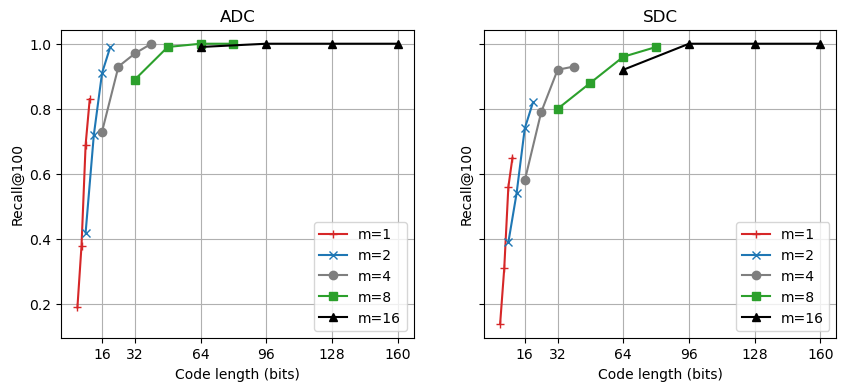

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, m in enumerate(Ms):
    asym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==True)]
    axs[0].plot(asym_res["Code length [bits]"], asym_res["Recall@100"], marker=markers[i], color=colors[i], label=f"m={m}")
    sym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==False)]
    axs[1].plot(sym_res["Code length [bits]"], sym_res["Recall@100"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].set_xticks([16, 32, 64, 96, 128, 160])
axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Recall@100")
axs[0].set_title("ADC")
axs[0].legend()
axs[0].grid()
axs[1].set_xticks([16, 32, 64, 96, 128, 160])
axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Recall@100")
axs[1].set_title("SDC")
axs[1].legend()
axs[1].grid()

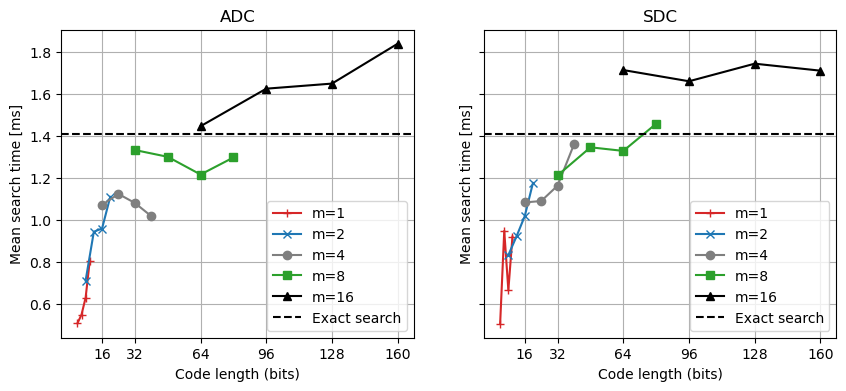

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
for i, m in enumerate(Ms):
    asym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==True)]
    axs[0].plot(asym_res["Code length [bits]"], asym_res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"m={m}")
    sym_res = search_results[(search_results["M"]==m) &(search_results["Asymmetric Distance"]==False)]
    axs[1].plot(sym_res["Code length [bits]"], sym_res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"m={m}")

axs[0].axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")
axs[1].axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")

axs[0].set_xticks([16, 32, 64, 96, 128, 160])
axs[0].set_xlabel("Code length (bits)")
axs[0].set_ylabel("Mean search time [ms]")
axs[0].set_title("ADC")
axs[0].legend()
axs[0].grid()
axs[1].set_xticks([16, 32, 64, 96, 128, 160])
axs[1].set_xlabel("Code length (bits)")
axs[1].set_ylabel("Mean search time [ms]")
axs[1].set_title("SDC")
axs[1].legend()
axs[1].grid()

In [30]:
K = 256
Ms = [1, 2, 4, 8, 16]
if DATASET == "siftsmall":
    Kps = [16, 128]
    ws = [1, 2, 8]
else:
    Kps = [1024, 8192]
    ws = [1, 8, 64]

ivf_training_results = []
ivf_search_results = []

for m in Ms:
    for Kp in Kps:
        print(f"Training PQ with M={m}, K'={Kp}...")
        
        ivf = IVF(Kp=Kp, M=m, K=K, seed=RANDOM_SEED)
        start_training = time.time()
        ivf.train(tr_data, add=False)
        training_time = time.time() - start_training
        start_adding = time.time()
        ivf.add(search_data)
        adding_time = time.time() - start_adding

        code_length = np.log2(K) * m
        curr_training_res = {"M": m, "K": K, "Kp": Kp,
                             "Code length [bits]": code_length,
                             "Training time [s]": training_time,
                             "Adding time [s]": adding_time}
        ivf_training_results.append(curr_training_res)
        
        for w in ws:
            if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
                continue
            mean_search_time = 0
            recall = 0
            for i, query in enumerate(queries):
                start_search = time.time()
                _, ranking = ivf.search(query, w=w, asym=True, correct=False)
                mean_search_time += (time.time() - start_search)
                if exact_nearest[i] in ranking[:100]:
                    recall += 1
            mean_search_time /= len(queries)
            recall /= len(queries)
            
            curr_search_res = {"M": m, "K": K, "Kp": Kp, "w":w,
                               "Code length [bits]": code_length,
                               "Mean search time [ms]": mean_search_time*1000,
                               "Recall@100": recall}
            ivf_search_results.append(curr_search_res)

ivf_training_results = pd.DataFrame(ivf_training_results)
ivf_search_results = pd.DataFrame(ivf_search_results)

Training PQ with M=1, K'=16...
Training PQ with M=1, K'=128...
Training PQ with M=2, K'=16...
Training PQ with M=2, K'=128...
Training PQ with M=4, K'=16...
Training PQ with M=4, K'=128...
Training PQ with M=8, K'=16...
Training PQ with M=8, K'=128...
Training PQ with M=16, K'=16...
Training PQ with M=16, K'=128...


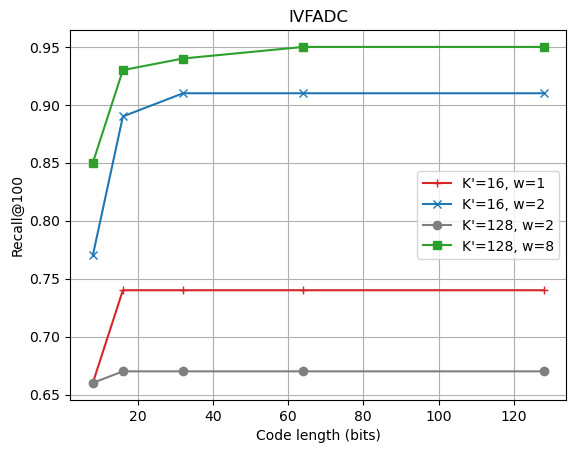

In [31]:
i = 0
for Kp in Kps:
    for w in ws:
        if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
                continue
        res = ivf_search_results[(ivf_search_results["Kp"]==Kp) & (ivf_search_results["w"]==w)]
        plt.plot(res["Code length [bits]"], res["Recall@100"], marker=markers[i], color=colors[i], label=f"K'={Kp}, w={w}")
        i += 1

plt.xlabel("Code length (bits)")
plt.ylabel("Recall@100")
plt.title("IVFADC")
plt.legend()
plt.grid()

# TODO: eventualmente inserisci in unico plot a confronto con altri

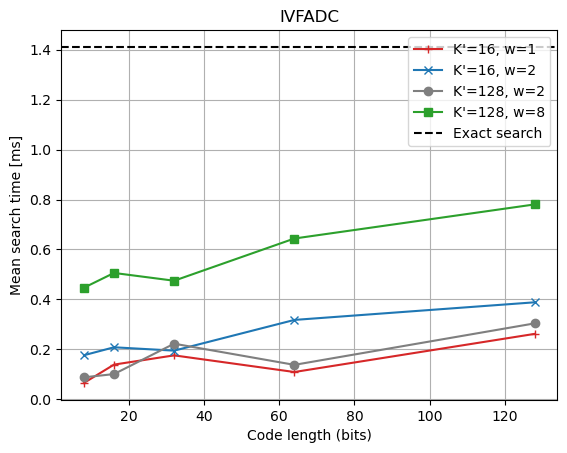

In [32]:
i = 0
for Kp in Kps:
    for w in ws:
        if (Kp == Kps[0] and w == ws[-1]) or (Kp == Kps[-1] and w == ws[0]):
            continue
        res = ivf_search_results[(ivf_search_results["Kp"]==Kp) & (ivf_search_results["w"]==w)]
        plt.plot(res["Code length [bits]"], res["Mean search time [ms]"], marker=markers[i], color=colors[i], label=f"K'={Kp}, w={w}")
        i += 1

plt.axhline(mean_es_time*1000, 0, 32, color='black', linestyle='--', label="Exact search")

plt.xlabel("Code length (bits)")
plt.ylabel("Mean search time [ms]")
plt.title("IVFADC")
plt.legend()
plt.grid()
# TODO: eventualmente inserisci in unico plot a confronto con altri

In [33]:
ivf_search_results[(ivf_search_results["M"]==8)]

,M,K,Kp,w,Code length [bits],Mean search time [ms],Recall@100
12,8,256,16,1,64.0,0.108752,0.74
13,8,256,16,2,64.0,0.317457,0.91
14,8,256,128,2,64.0,0.137439,0.67
15,8,256,128,8,64.0,0.643685,0.95


In [34]:
search_results[(search_results["M"]==8) & (search_results["K"]==256)]

,M,K,Code length [bits],Asymmetric Distance,Mean search time [ms],Recall@100
28,8,256,64.0,True,1.216409,1.00
29,8,256,64.0,False,1.328752,0.96


<img src="./img/sift_img.png" alt="My Image" width="500"/>

For the m = 4 SIFT quantizer, this means that the 4×4 patch cells that make up the descriptor are grouped into 4 2 × 2 blocks. For the other two, it groups together dimensions that have have the same index modulo 8.

In [35]:
struct_perm = list(range(0, 16)) + list(range(32, 48)) + \
    list(range(16, 32)) + list(range(48, 64)) + \
    list(range(64, 80)) + list(range(96, 112)) + \
    list(range(80, 96)) + list(range(112, 128))
tr_data_struct_perm = tr_data[:, struct_perm]
queries_struct_perm = queries[:, struct_perm]
search_data_struct_perm = search_data[:, struct_perm]

pq_struct_perm = PQ(M=4, K=K, seed=RANDOM_SEED)
print("Training PQ with structured permutation...")
pq_struct_perm.train(tr_data_struct_perm, add=False)
pq_struct_perm.add(search_data_struct_perm)

recall_struct_perm = np.zeros(queries_struct_perm.shape[0])
for i, query in enumerate(queries_struct_perm):
    _, asym_struct_perm_rank = pq_struct_perm.search(query, subset=None, asym=True, correct=False)
    recall_struct_perm[i] = exact_nearest[i] in asym_struct_perm_rank[:10]
recall_struct_perm = np.mean(recall_struct_perm)

pq = PQ(M=4, K=K, seed=RANDOM_SEED)
print("Training PQ with natural permutation...")
pq.train(tr_data, add=False)
pq.add(search_data)

recall = np.zeros(queries.shape[0])
for i, query in enumerate(queries):
    _, asym_rank = pq.search(query, subset=None, asym=True, correct=False)
    recall[i] = exact_nearest[i] in asym_rank[:10]
recall = np.mean(recall)

recalls_rand_perm = []
for rep in range(0, 5):
    rand_perm = np.random.permutation(128)
    tr_data_rand_perm = tr_data[:, rand_perm]
    queries_rand_perm = queries[:, rand_perm]
    search_data_rand_perm = search_data[:, rand_perm]

    pq_rand_perm = PQ(M=4, K=K, seed=RANDOM_SEED)
    print(f"[{rep+1}/5] Training PQ with random permutation...")
    pq_rand_perm.train(tr_data_rand_perm, add=False)
    pq_rand_perm.add(search_data_rand_perm)

    recall_rand_perm = np.zeros(queries_rand_perm.shape[0])
    for i, query in enumerate(queries_rand_perm):
        _, asym_rand_perm_rank = pq_rand_perm.search(query, subset=None, asym=True, correct=False)
        recall_rand_perm[i] = exact_nearest[i] in asym_rand_perm_rank[:10]
    recall_rand_perm = np.mean(recall_rand_perm)

    recalls_rand_perm.append(recall_rand_perm)

recall_rand_perm_mean = np.mean(recalls_rand_perm)
recall_rand_perm_std = np.std(recalls_rand_perm)

pd.DataFrame({
    "natural": [recall],
    "structured": [recall_struct_perm],
    "random mean": [recall_rand_perm_mean],
    "random std": [recall_rand_perm_std]
}, index=["recall@10"])

Training PQ with structured permutation...
Training PQ with natural permutation...
[1/5] Training PQ with random permutation...
[2/5] Training PQ with random permutation...
[3/5] Training PQ with random permutation...
[4/5] Training PQ with random permutation...
[5/5] Training PQ with random permutation...


,natural,structured,random mean,random std
recall@10,0.73,0.73,0.688,0.027129


In [36]:
KP*128, 10000/KP
# numero di entries da confrontare per ogni query
# punti per centroide

(16384, 78.125)

In [37]:
# dist_table:
#   1 ... 256
# 1
# 2
# 3
# 4

# pqcode:
#    1     2     3     4
# p1 1-256
# ...
# pn

# dist_table[[1, 2, 3, 4]], pqcode]